In [1]:
import numpy as np
import pandas as pd

In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline
from plot_functions import *
from sklearn.model_selection import KFold

In [3]:
from create_matrix import *
import os
from tensor_custom_core import *
from create_matrix import *
from tensor_custom_core import *
from degree_days import dds
import sys


appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}
APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
region = "SanDiego"
year = 2014




def un_normalize(x, maximum, minimum):
    return (maximum - minimum) * x + minimum

In [4]:
n_splits = 10
case=2
cost='abs'

In [5]:
def get_tensor(df, dfc):
    start, stop = 1, 13
    energy_cols = np.array(
        [['%s_%d' % (appliance, month) for month in range(start, stop)] for appliance in APPLIANCES_ORDER]).flatten()

    static_cols = ['area', 'total_occupants', 'num_rooms']
    static_df = df[static_cols]
    static_df = static_df.div(static_df.max())
    weather_values = np.array(dds[2014][region][start - 1:stop - 1]).reshape(-1, 1)

    dfc = df.copy()

    df = dfc[energy_cols]
    col_max = df.max().max()
    col_min = df.min().min()
    # df = (1.0 * (df - col_min)) / (col_max - col_min)
    tensor = df.values.reshape((len(df), 7, stop - start))
    M, N, O = tensor.shape
    return tensor

In [6]:
sd_df, sd_dfc = create_matrix_single_region("SanDiego", year)
sd_tensor = get_tensor(sd_df, sd_dfc)
au_df, au_dfc = create_matrix_single_region("Austin", year)
au_tensor = get_tensor(au_df, au_dfc)

In [7]:
from sklearn.model_selection import train_test_split, KFold
from common import compute_rmse

In [8]:
iters = 1000
a = 3

In [91]:
H_series = {}
A_series = {}
T_series = {}
HAT_series = {}
cost_series = {}
HAT_au = {}

H, A, T, Hs_au, As_au, Ts_au, HATs_au, costs_au = learn_HAT_random_normal(case, au_tensor, a, a, num_iter=10000, lr=0.1, dis=False, cost_function=cost, T_known=np.ones(12).reshape(-1, 1))

for iters in [1000, 2000, 4000, 6000, 8000, 10000]:

    H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_random_normal(case, sd_tensor, a, a, num_iter=10000, lr=0.1, dis=False, cost_function=cost,A_known = As_au[iters], T_known=np.ones(12).reshape(-1, 1))
    
    H_series[iters] = Hs
    A_series[iters] = As
    T_series[iters] = Ts
    HAT_series[iters] = HATs
    cost_series[iters] = costs

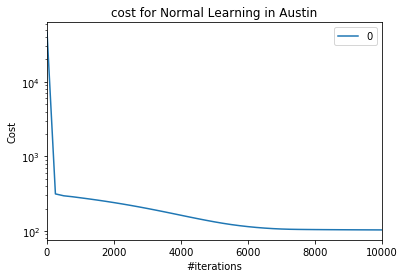

In [93]:
step=250
idx = np.arange(0, 10100, 250)

tdf = pd.DataFrame(costs_au[::step], index=idx)
tdf.plot(logy=True)
plt.title("cost for Normal Learning in Austin")
plt.ylabel("Cost")
plt.xlabel("#iterations")

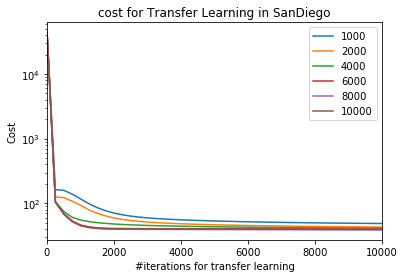

In [114]:
step=250
idx = np.arange(0, 10100, 250)
dfs = pd.DataFrame(cost_series[1000][::step], index=idx, columns={str(1000)})
for iters in [2000, 4000, 6000, 8000, 10000]:
    tdf = pd.DataFrame(cost_series[iters][::step], index=idx, columns={str(iters)})
    dfs = pd.concat([dfs, tdf], axis = 1)
dfs.plot(logy=True)
plt.title("cost for Transfer Learning in SanDiego")
plt.ylabel("Cost")
plt.xlabel("#iterations for transfer learning")

In [95]:
pred = {}   
        
for iters in [1000, 2000, 4000, 6000, 8000, 10000]:
    pred[iters] = {}
    for appliance in APPLIANCES_ORDER:
        pred[iters][appliance] = {f:[] for f in range(250, 10010, 250)}
        
for iters in [1000, 2000, 4000, 6000, 8000, 10000]:
    for iter_transfer in range(250, 10010, 250):
        for appliance_name, appliance_id in appliance_index.iteritems():
            pred[iters][appliance_name][iter_transfer].append(pd.DataFrame(HAT_series[iters][iter_transfer][:, appliance_id, :], index=sd_df.index))

In [96]:
from common import compute_rmse_fraction

out = {}

for iters in [1000, 2000, 4000, 6000, 8000, 10000]:
    out[iters] = {}    
    for appliance in APPLIANCES_ORDER[1:]:
        out[iters][appliance] = {}
        for f in range(250, 10010, 250):
            s = pd.concat(pred[iters][appliance][f]).ix[sd_df.index]
            if appliance=="hvac":
                out[iters][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
            else:   
                out[iters][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

/home/yj9xs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


In [99]:
pd_out = {}
for iters in [1000, 2000, 4000, 6000, 8000, 10000]:
    pd_out[iters] = pd.DataFrame(out[iters])
    pd_out[iters] = pd_out[iters].rename( columns = 
                                         {'dw': "dw_" + str(iters),
                                          'wm': "wm_" + str(iters),
                                          'mw': "mw_" + str(iters),
                                          'oven': "oven_" + str(iters),
                                          'fridge': "fridge_"+ str(iters),
                                          'hvac': "hvac_" + str(iters)})

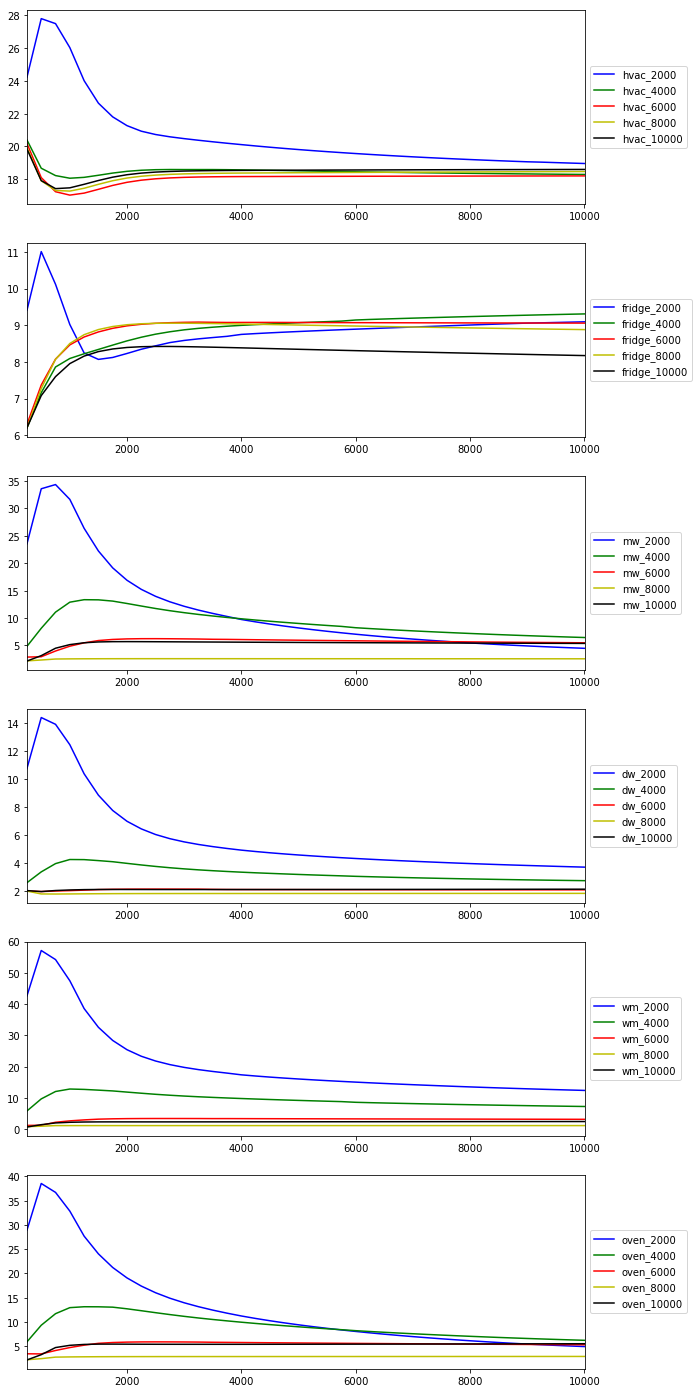

In [107]:
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(10, 15))
ax = axes.flatten()
count = 0


# df['A'].plot(ax=axes[0,0]); axes[0,0].set_title('A')
for appliance in APPLIANCES_ORDER[1:]:
    dfs = {}
    num = 0
    for iters in [2000, 4000, 6000, 8000, 10000]:
        dfs[num] = pd_out[iters][appliance + "_" + str(iters)]
        num += 1
    df = pd.concat([dfs[0], dfs[1]], axis = 1)
    for i in range(2, 5):
        df = pd.concat([df, dfs[i]], axis = 1)

    pd.DataFrame(df).plot(ax=ax[count],figsize=(10, 25),xlim=(250, 10010), color=['b', 'g','r', 'y', 'k', 'c'])
    ax[count].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    count += 1
# plt.savefig("./analysis/transfer_const_1_628.png", bbox_inches="tight", dpi=300)